In [1]:
import os

import pickle
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

from yellowbrick.cluster import silhouette_visualizer, intercluster_distance, kelbow_visualizer

In [2]:
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words
        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters
    
    def learn(self):
        sift = cv.SIFT_create()
        num_keypoints = [] #this is used to store the number of keypoints in each image
        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)
        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_
        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)
        return training_word_histograms

    def create_word_histograms(self, img_filenames):
        sift = cv.SIFT_create()
        histograms = []
        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image
            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching
                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
                    histogram[matching_word_ID] += 1
                histogram /= len(descriptors) #normalise histogram to frequencies
            histograms.append(histogram)
        return histograms

In [3]:
breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
for i, breed in enumerate(breeds):
    sub_path = path + 'filtered_train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels

print(training_file_names)
print(training_breed_labels)

['images/filtered_train/shiba_inu_1.jpg', 'images/filtered_train/shiba_inu_100.jpg', 'images/filtered_train/shiba_inu_101.jpg', 'images/filtered_train/shiba_inu_103.jpg', 'images/filtered_train/shiba_inu_108.jpg', 'images/filtered_train/shiba_inu_11.jpg', 'images/filtered_train/shiba_inu_110.jpg', 'images/filtered_train/shiba_inu_111.jpg', 'images/filtered_train/shiba_inu_112.jpg', 'images/filtered_train/shiba_inu_113.jpg', 'images/filtered_train/shiba_inu_116.jpg', 'images/filtered_train/shiba_inu_126.jpg', 'images/filtered_train/shiba_inu_128.jpg', 'images/filtered_train/shiba_inu_131.jpg', 'images/filtered_train/shiba_inu_132.jpg', 'images/filtered_train/shiba_inu_133.jpg', 'images/filtered_train/shiba_inu_137.jpg', 'images/filtered_train/shiba_inu_139.jpg', 'images/filtered_train/shiba_inu_14.jpg', 'images/filtered_train/shiba_inu_140.jpg', 'images/filtered_train/shiba_inu_141.jpg', 'images/filtered_train/shiba_inu_142.jpg', 'images/filtered_train/shiba_inu_147.jpg', 'images/filter

In [4]:
sift = cv.SIFT_create()
num_keypoints = [] #this is used to store the number of keypoints in each image
training_data = []
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)

training_data = np.array(training_data)

# 2.1 K-elbow Visualization

In [5]:
# # Kelbow distortion plot
# print("Generating kelbow plot...")
# kelbow_vis_distortion = kelbow_visualizer(KMeans(), training_data, k=[25,50,100,200,500], metric="distortion")

# # Kelbow calinski_harabasz plot
# kelbow_vis_calinski = kelbow_visualizer(KMeans(), training_data, k=[25,50,100,200,500], metric="calinski_harabasz")

# 2.2 Word Histograms for train, val and test data

In [6]:
breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
validation_file_names = []
validation_breed_labels = []
testing_file_names = []
testing_breed_labels = []
for i, breed in enumerate(breeds):
    # Training Data
    sub_path = path + 'filtered_train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels
    # Validation Data
    sub_path = path + 'filtered_val/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    validation_file_names += sub_file_names
    validation_breed_labels += sub_breed_labels
    # Testing Data
    sub_path = path + 'test/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    testing_file_names += sub_file_names
    testing_breed_labels += sub_breed_labels

print(training_file_names)
print(training_breed_labels)

print(validation_file_names)
print(validation_breed_labels)

['images/filtered_train/shiba_inu_1.jpg', 'images/filtered_train/shiba_inu_100.jpg', 'images/filtered_train/shiba_inu_101.jpg', 'images/filtered_train/shiba_inu_103.jpg', 'images/filtered_train/shiba_inu_108.jpg', 'images/filtered_train/shiba_inu_11.jpg', 'images/filtered_train/shiba_inu_110.jpg', 'images/filtered_train/shiba_inu_111.jpg', 'images/filtered_train/shiba_inu_112.jpg', 'images/filtered_train/shiba_inu_113.jpg', 'images/filtered_train/shiba_inu_116.jpg', 'images/filtered_train/shiba_inu_126.jpg', 'images/filtered_train/shiba_inu_128.jpg', 'images/filtered_train/shiba_inu_131.jpg', 'images/filtered_train/shiba_inu_132.jpg', 'images/filtered_train/shiba_inu_133.jpg', 'images/filtered_train/shiba_inu_137.jpg', 'images/filtered_train/shiba_inu_139.jpg', 'images/filtered_train/shiba_inu_14.jpg', 'images/filtered_train/shiba_inu_140.jpg', 'images/filtered_train/shiba_inu_141.jpg', 'images/filtered_train/shiba_inu_142.jpg', 'images/filtered_train/shiba_inu_147.jpg', 'images/filter

In [7]:
num_words = 50
dictionary_name = 'breeds'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

In [8]:
training_word_histograms = dictionary.learn()
validation_word_histograms = dictionary.create_word_histograms(validation_file_names)

c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
# Save Dictionary
with open('breeds_dictionary.dic', 'wb') as f: #'wb' is for binary write
    pickle.dump(dictionary, f)

In [10]:
# Read Dictionary
with open('breeds_dictionary.dic', 'rb') as f: #'rb' is for binary read
    dictionary = pickle.load(f)

# 2.2 SVM

In [11]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
C = [0.1, 1, 10, 20, 30, 40, 50, 100]

In [12]:
for c in C:
    # SVM classifier
    svm_classifier = svm.SVC(C = c, kernel = 'linear')
    svm_classifier.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = svm_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = svm_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

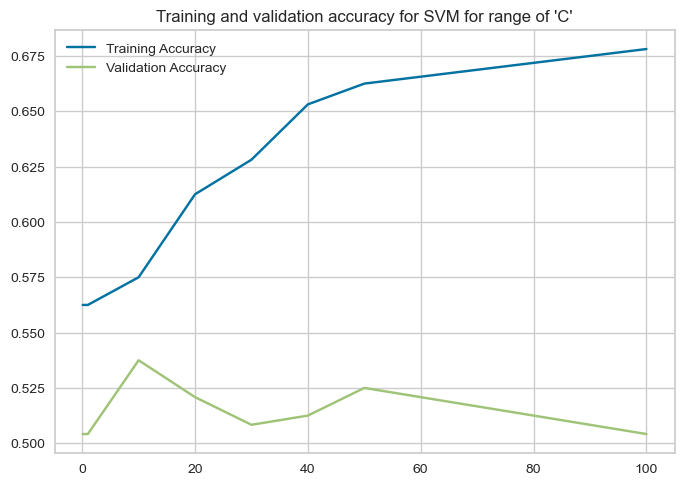

In [13]:
# Plot the results
plt.plot(C, training_accuracies, label='Training Accuracy')
plt.plot(C, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for SVM for range of 'C'")
plt.show()

# 2.3 SVM

In [14]:
best_c = C[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for number of C with the best validation accuracy is {best_c} with an accuracy of {best_val_acc:.2%}")

The value for number of C with the best validation accuracy is 10 with an accuracy of 53.75%


In [15]:
# Re-train and save best model
svm_classifier = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_breed_labels)
with open('best_SVM.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(svm_classifier, f)

In [16]:
predicted_breed_labels = svm_classifier.predict(validation_word_histograms)
print('Breed label: ', predicted_breed_labels)

Breed label:  [0 1 2 0 0 1 0 3 2 0 3 1 0 0 3 1 2 2 0 0 0 1 1 2 2 2 0 2 1 0 2 1 3 1 0 0 0
 0 0 0 1 0 1 0 0 3 1 2 2 1 3 0 0 2 0 0 2 0 2 0 2 1 1 2 1 1 1 1 1 1 0 2 0 1
 2 0 1 1 0 1 1 1 2 0 0 0 2 1 0 0 1 1 1 0 0 1 1 1 2 3 2 1 2 0 1 1 2 1 1 1 0
 2 1 1 1 0 1 1 1 2 2 2 2 1 1 2 1 2 1 2 1 2 2 2 2 2 2 1 3 3 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 0 2 2 3 2 2 2 2 0 2 1
 3 3 0 2 3 3 2 3 3 3 2 3 3 2 3 3 1 2 2 2 1 1 3 1 3 0 3 1 3 1 2 2 1 3 2 1 2
 1 0 3 3 2 3 0 0 3 2 3 0 1 1 2 2 3 3]


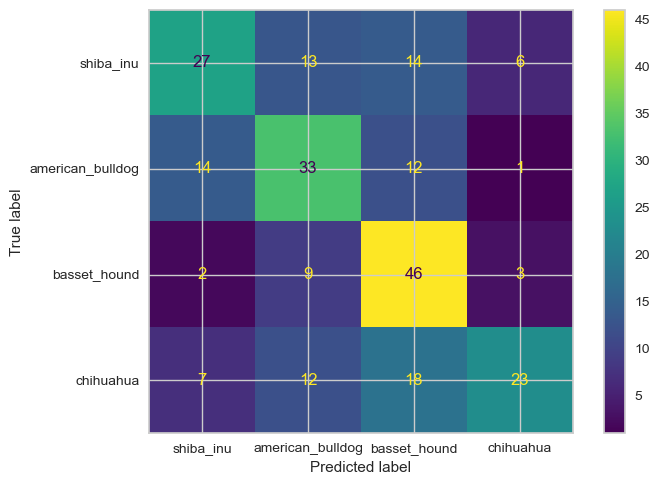

In [17]:
# C = 100
cm = confusion_matrix(validation_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot()
plt.show()

# 2.2 Adaboost

In [18]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
n_estimator_range = [50, 100, 150, 200, 250]

In [19]:
for n_estimator in n_estimator_range:
    # Adaboost classifier
    adb_classifier = AdaBoostClassifier(n_estimators = n_estimator, random_state = 0)
    adb_classifier.fit(training_word_histograms, training_breed_labels)
    
    # Get accuracy on training dataset
    training_pred = adb_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = adb_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

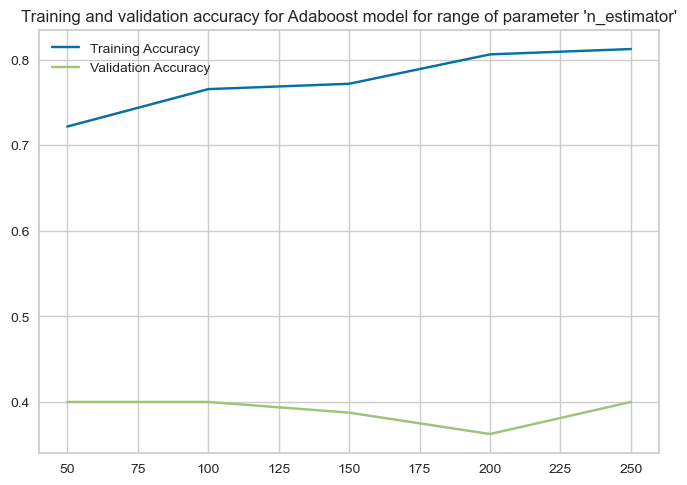

In [20]:
# Plot the results
plt.plot(n_estimator_range, training_accuracies, label='Training Accuracy')
plt.plot(n_estimator_range, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for Adaboost model for range of parameter 'n_estimator'")
plt.show()

# 2.3 Adaboost

In [21]:
best_n = n_estimator_range[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for N-estimator with the best validation accuracy is {best_n} with an accuracy of {best_val_acc:.2%}")

The value for N-estimator with the best validation accuracy is 50 with an accuracy of 40.00%


In [22]:
# Re-train and save best model
adb_classifier = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier.fit(training_word_histograms, training_breed_labels)
with open('best_Ada.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(adb_classifier, f)

Breed label:  [3 1 3 0 1 1 3 2 3 0 3 1 0 1 1 2 2 3 1 1 1 1 2 1 2 0 0 2 1 1 2 1 0 0 3 0 1
 3 0 0 1 0 0 1 0 3 1 2 2 3 1 1 0 1 1 1 2 0 2 1 2 2 3 1 1 1 1 1 0 1 0 2 2 3
 1 1 0 0 0 1 1 1 2 0 0 0 2 1 0 0 0 1 1 0 0 1 0 2 2 1 2 1 3 1 1 1 1 1 0 3 1
 2 3 0 1 0 1 2 0 2 2 1 2 1 0 1 1 1 2 2 2 2 2 2 2 1 1 1 2 1 2 2 1 2 2 1 2 1
 2 1 2 2 2 2 0 2 1 2 1 2 2 2 2 1 2 1 1 2 2 2 3 1 2 2 1 1 1 3 2 2 1 2 2 2 3
 0 0 1 1 3 3 2 3 3 1 3 1 0 0 3 2 1 3 1 1 1 1 3 1 3 3 1 0 3 3 1 3 1 3 3 1 1
 3 3 3 3 2 1 3 0 3 1 1 0 1 0 2 1 0 1]


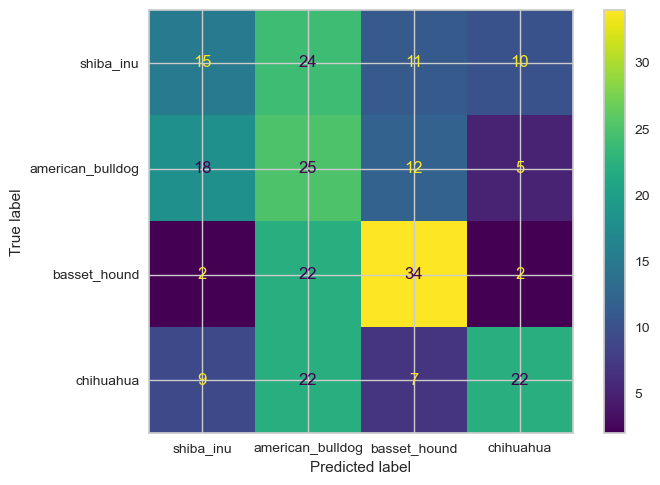

In [23]:
predicted_breed_labels = adb_classifier.predict(validation_word_histograms)
print('Breed label: ', predicted_breed_labels)
# n_estimator = 200
cm = confusion_matrix(validation_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot()
plt.show()